# 1. Regressive Tennis T-Test

Use a linear regression and statsmodels to run a t-test on whether Federer scores more points than his opponents in the `tennis.csv` dataset.

Give a one-paragraph interpretation of the coefficient, and the meaning of the p-value. 

Also answer the following: should your regression include a constant term? Why or why not? How would it change the interpretation of your coefficient and p-value?

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import seaborn as sns

df = pd.read_csv('data/tennis.csv')
df

,year,tournament,start date,type,surface,draw,atp points,atp ranking,tournament prize money,round,...,player2 break points converted won,player2 break points converted total,player2 return games played,player2 total service points won,player2 total service points total,player2 total return points won,player2 total return points total,player2 total points won,player2 total points total,win
0,1998,"Basel, Switzerland",1998-10-05,WS,Indoor: Hard,Draw: 32,1,396.0,"$9,800",R32,...,4.0,8.0,8.0,36.0,50.0,26.0,53.0,62.0,103.0,False
1,1998,"Toulouse, France",1998-09-28,WS,Indoor: Hard,Draw: 32,59,878.0,"$10,800",R32,...,0.0,1.0,8.0,33.0,65.0,8.0,41.0,41.0,106.0,True
2,1998,"Toulouse, France",1998-09-28,WS,Indoor: Hard,Draw: 32,59,878.0,"$10,800",R16,...,0.0,4.0,10.0,46.0,75.0,23.0,73.0,69.0,148.0,True
3,1998,"Toulouse, France",1998-09-28,WS,Indoor: Hard,Draw: 32,59,878.0,"$10,800",Q,...,3.0,10.0,10.0,44.0,63.0,26.0,67.0,70.0,130.0,False
4,1998,"Geneva, Switzerland",1998-08-24,CH,Outdoor: Clay,Draw: 32,1,680.0,$520,R32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174,2012,"Australian Open, Australia",2012-01-16,GS,Outdoor: Hard,Draw: 128,720,3.0,"A$437,000",S,...,6.0,16.0,21.0,95.0,141.0,51.0,135.0,146.0,276.0,False
1175,2012,"Doha, Qatar",2012-01-02,250,Outdoor: Hard,Draw: 32,90,3.0,"$50,030",R32,...,0.0,0.0,8.0,22.0,45.0,9.0,41.0,31.0,86.0,True
1176,2012,"Doha, Qatar",2012-01-02,250,Outdoor: Hard,Draw: 32,90,3.0,"$50,030",R16,...,0.0,2.0,9.0,28.0,50.0,11.0,49.0,39.0,99.0,True
1177,2012,"Doha, Qatar",2012-01-02,250,Outdoor: Hard,Draw: 32,90,3.0,"$50,030",Q,...,4.0,9.0,16.0,47.0,78.0,34.0,95.0,81.0,173.0,True


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     player2 total points won   R-squared:                       0.880
Model:                                  OLS   Adj. R-squared:                  0.880
Method:                       Least Squares   F-statistic:                     8619.
Date:                      Wed, 13 Jan 2021   Prob (F-statistic):               0.00
Time:                              19:42:04   Log-Likelihood:                -4699.0
No. Observations:                      1179   AIC:                             9402.
Df Residuals:                          1177   BIC:                             9412.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -3.9388      0.828     -4.756      0.000      -5.564      -2.314
player1 total points won     0.9030      0.010     92.836      0.000       0.884       0.922
==============================================================================
Omnibus:                       72.475   Durbin-Watson:                   1.694
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.996
Skew:                           0.622   Prob(JB):                     3.49e-19
Kurtosis:                       3.430   Cond. No.                         186.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

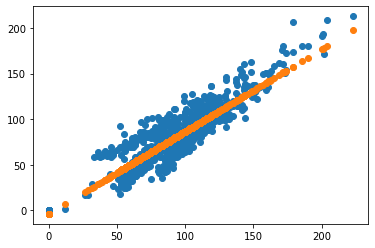

In [14]:
df = df.fillna(0)
x = df['player1 total points won']
y = df['player2 total points won']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
y_fed = est.predict(x)

plt.scatter(x.iloc[:,1], y)
plt.scatter(x['player1 total points won'],y_fed)
est.summary()

In [15]:
#From what we can see, Federer scored more total points overall compared to his opponent with a coef of 0.903. The standard error is small and therefore fairly accurate. Since P > |T| is 0.000, we can assume that the statistics are significant. Furthermore, the R-squared is 0.88 and therefore fairly high, meaning that we can further reject our null hypothesis.
#When plotted without the constant, we got a higher R-squared value and the coefficients and p-value were still significant. However, the R-squared was "uncentered" and therefore not valid. It was better to add a constant in this case.

# 2. College admissions

Using the `college.csv` dataset, answer the following:

1. Is the relation between `Top10perc` and `Top25perc` best fit using a model with only one variable, or one variable and a polynomial of degree 2? Is a constant term useful? How would you select for the best of these model specifications?

2. Do private schools see more admissions overall? T-test this using a linear regression. Hint: use a binary explanatory variable for `Private`. Explain your model specification choices.


In [16]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

df = pd.read_csv('data/College.csv')
df

,Unnamed: 0,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,Worcester State College,No,2197,1515,543,4,26,3089,2029,6797,3900,500,1200,60,60,21.0,14,4469,40
773,Xavier University,Yes,1959,1805,695,24,47,2849,1107,11520,4960,600,1250,73,75,13.3,31,9189,83
774,Xavier University of Louisiana,Yes,2097,1915,695,34,61,2793,166,6900,4200,617,781,67,75,14.4,20,8323,49
775,Yale University,Yes,10705,2453,1317,95,99,5217,83,19840,6510,630,2115,96,96,5.8,49,40386,99


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              Top25perc   R-squared (uncentered):                   0.911
Model:                            OLS   Adj. R-squared (uncentered):              0.911
Method:                 Least Squares   F-statistic:                              7971.
Date:                Wed, 13 Jan 2021   Prob (F-statistic):                        0.00
Time:                        19:42:05   Log-Likelihood:                         -3332.4
No. Observations:                 777   AIC:                                      6667.
Df Residuals:                     776   BIC:                                      6671.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Top10perc      1.7275      0.019     89.281      0.000       1.690       1.766
==============================================================================
Omnibus:                      290.739   Durbin-Watson:                   1.499
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1310.349
Skew:                          -1.681   Prob(JB):                    2.89e-285
Kurtosis:                       8.401   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

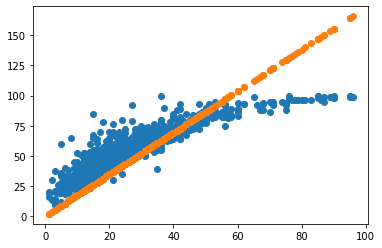

In [17]:
#Gives good R-squared (uncentered) value and std. error is low, despite no constant.
x = df['Top10perc']
y = df['Top25perc']

est = sm.OLS(y, x).fit()
yfit = est.predict(x)

plt.scatter(x, y)
plt.scatter(x,yfit)
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Top25perc   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     3018.
Date:                Wed, 13 Jan 2021   Prob (F-statistic):          1.87e-269
Time:                        19:43:57   Log-Likelihood:                -2805.2
No. Observations:                 777   AIC:                             5614.
Df Residuals:                     775   BIC:                             5624.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.1984      0.596     47.281      0.000      27.028      29.369
Top10perc      1.0014      0.018     54.933      0.000       0.966       1.037
==============================================================================
Omnibus:                       45.943   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.462
Skew:                           0.401   Prob(JB):                     2.77e-19
Kurtosis:                       4.413   Cond. No.                         60.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

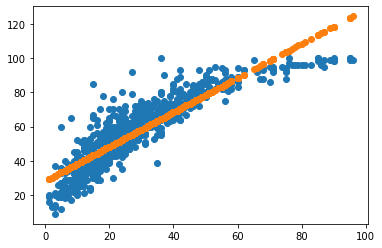

In [19]:
#adding a constant lowers the R-squared (less favorable), but std. error is about the same.
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
yfit = est.predict(x)

plt.scatter(x.iloc[:,1], y)
plt.scatter(x['Top10perc'],yfit)
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Top25perc   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     2220.
Date:                Wed, 13 Jan 2021   Prob (F-statistic):          2.50e-321
Time:                        19:44:12   Log-Likelihood:                -2681.0
No. Observations:                 777   AIC:                             5368.
Df Residuals:                     774   BIC:                             5382.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.6786      0.845     19.738      0.000      15.020      18.337
Top10perc      1.8140      0.050     36.229      0.000       1.716       1.912
Top10perc2    -0.0102      0.001    -17.072      0.000      -0.011      -0.009
==============================================================================
Omnibus:                      177.730   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              570.823
Skew:                           1.089   Prob(JB):                    1.12e-124
Kurtosis:                       6.590   Cond. No.                     5.65e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.65e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

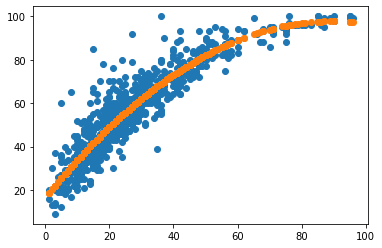

In [20]:
#Squaring value gets R-shared 0.852, which is still lower than the original linear regression. However, the regression line fits the data better than the previous lines.
df['Top10perc2'] = (df.Top10perc ** 2)
X = sm.add_constant(df[['Top10perc', 'Top10perc2']])
est = sm.OLS(df.Top25perc, X).fit()
yfit = est.predict(X)

plt.scatter(x.iloc[:,1], y)
plt.scatter(x['Top10perc'],yfit)
est.summary()

In [ ]:
#Selected degree 2 for the data because the data was clearly curving in the previous graphs, whereas the regression line was too linear. The squared regression line is more accurate.

In [21]:
x = pd.get_dummies(df.Private, drop_first=True)
X = sm.add_constant(x)
est = sm.OLS(df.Enroll, X).fit()
yfit = est.predict(X)

est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Enroll   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     368.9
Date:                Wed, 13 Jan 2021   Prob (F-statistic):           1.49e-67
Time:                        20:38:07   Log-Likelihood:                -6261.0
No. Observations:                 777   AIC:                         1.253e+04
Df Residuals:                     775   BIC:                         1.254e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1640.8726     52.560     31.219      0.000    1537.695    1744.050
Yes        -1183.9275     61.637    -19.208      0.000   -1304.924   -1062.931
==============================================================================
Omnibus:                      421.162   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3666.463
Skew:                           2.310   Prob(JB):                         0.00
Kurtosis:                      12.587   Cond. No.                         3.60
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#From what we see, 1183 fewer people enrolled in private schools compared to public. The R-squared (low) and std error (high) are issues, but the t-test for 'Yes' values indicates that the data is still significant.

# 3. Auto prediction

Using the `auto.csv` dataset, perform a simple linear regression with `mpg` as the response variable and horsepower as the predictor. Answer the following:

 i. Is there a relationship between the predictor and the response?
 
 ii. How strong is the relationship between the predictor and the response?
 
 iii. Is the relationship between the predictor and the response positive or negative?

 iv. What is the predicted mpg associated with a horsepower of 98? What are the associated 95 % confidence and prediction intervals ?

 v. Make a regression plot the response and the predictor.

In [9]:
#Question 3.1
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
df = pd.read_csv('data/auto.csv', names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)
df = df.dropna()
df

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
2,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0
3,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0
4,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0
5,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0
6,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0
...,...,...,...,...,...,...,...,...
394,27.0,4.0,140.0,86.0,2790.0,15.6,82.0,1.0
395,44.0,4.0,97.0,52.0,2130.0,24.6,82.0,2.0
396,32.0,4.0,135.0,84.0,2295.0,11.6,82.0,1.0
397,28.0,4.0,120.0,79.0,2625.0,18.6,82.0,1.0


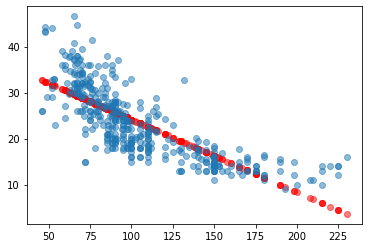

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    MPG   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Sat, 16 Jan 2021   Prob (F-statistic):           7.03e-81
Time:                        09:44:30   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9359      0.717     55.660      0.000      38.525      41.347
Horsepower    -0.1578      0.006    -24.489      0.000      -0.171      -0.145
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
#help from pam
x = df['Horsepower'].astype(float)
y = df['MPG'].astype(float)
x = sm.add_constant(x)

model = sm.OLS(y,x).fit()

pred = model.predict(x)
fig, ax = plt.subplots()
ax.scatter(x.iloc[:,1],pred,alpha=0.5,color='r')
ax.scatter(x.iloc[:,1],y,alpha=0.5)
plt.show()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    MPG   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     428.0
Date:                Sat, 16 Jan 2021   Prob (F-statistic):           5.40e-99
Time:                        09:23:33   Log-Likelihood:                -1133.2
No. Observations:                 392   AIC:                             2272.
Df Residuals:                     389   BIC:                             2284.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          56.9001      1.800     31.604      0.000      53.360      60.440
Horsepower     -0.4662      0.031    -14.978      0.000      -0.527      -0.405
Horsepower2     0.0012      0.000     10.080      0.000       0.001       0.001
==============================================================================
Omnibus:                       16.158   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.662
Skew:                           0.218   Prob(JB):                     2.20e-07
Kurtosis:                       4.299   Cond. No.                     1.29e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

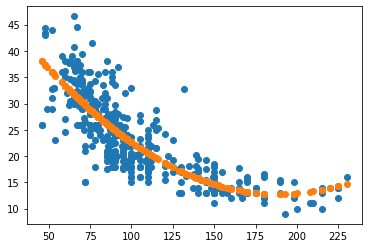

In [5]:
df['Horsepower2'] = (df.Horsepower ** 2).astype(float)
X = sm.add_constant(df[['Horsepower', 'Horsepower2']])
est = sm.OLS(y, X).fit()
yfit = est.predict(X)

plt.scatter(x.iloc[:,1], y)
plt.scatter(x['Horsepower'],yfit)
est.summary()

In [ ]:
#Question 3.2
#There is a relationship between the MPG and horsepower based on the
# coefficient of the squared horsepower value and the fact that there is
# 0 standard error.

In [ ]:
#Question 3.3
#The data is clearly decreasing; however, due to the fact that I took the squared value of the horsepower, the coefficient became positive.

In [6]:
#Question 3.4
x.loc[98]

const           1.0
Horsepower    175.0
Name: 98, dtype: float64

In [ ]:
#Confidence interval can be seen above (-0.527, -0.405). 
#Question 3.5 - plot above

# 4. Auto Multiple Regression

Perform a multiple linear regression with `mpg` as the response and all other variables except name in `auto` as the predictors. Comment on the output:

i. Is there a relationship between the predictors and the response?

ii. Which predictors appear to have a statistically significant relationship to the response?

iii. What does the coefficient for the year variable suggest?

iv. Comment on any problems you see with the fit. Do the residual plots suggest any unusually large outliers?

v. Is there heteroscedasticity in the fit?

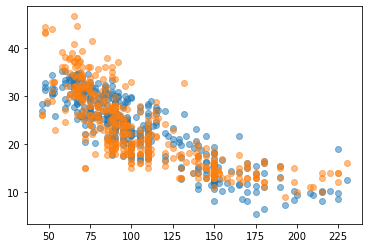

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    MPG   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     272.2
Date:                Sat, 16 Jan 2021   Prob (F-statistic):          3.79e-135
Time:                        10:06:25   Log-Likelihood:                -1036.5
No. Observations:                 392   AIC:                             2087.
Df Residuals:                     385   BIC:                             2115.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -14.5353      4.764     -3.051      0.002     -23.902      -5.169
Horsepower      -0.0004      0.014     -0.028      0.977      -0.028       0.027
Cylinders       -0.3299      0.332     -0.993      0.321      -0.983       0.323
Displacement     0.0077      0.007      1.044      0.297      -0.007       0.022
Acceleration     0.0853      0.102      0.836      0.404      -0.115       0.286
Weight          -0.0068      0.001    -10.141      0.000      -0.008      -0.005
Model Year       0.7534      0.053     14.318      0.000       0.650       0.857
==============================================================================
Omnibus:                       37.865   Durbin-Watson:                   1.232
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.248
Skew:                           0.630   Prob(JB):                     8.26e-14
Kurtosis:                       4.449   Cond. No.                     8.53e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.53e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
#Question 4.1
x = df[['Horsepower', 'Cylinders', 'Displacement', 'Acceleration', 'Weight', 'Model Year']].astype(float)
y = df['MPG'].astype(float)
x = sm.add_constant(x)

model = sm.OLS(y,x).fit()

pred = model.predict(x)
fig, ax = plt.subplots()
ax.scatter(x.iloc[:,1],pred,alpha=0.5)
ax.scatter(x.iloc[:,1],y,alpha=0.5)
plt.show()
model.summary()

In [ ]:
'''
Question 4.1: 
There is a relationship between some of the predictors with the MPG. Based on the R-squared, the data is significant. The t-test shows that there is a relationship between the MPG and the weight and model year when the MPG is compared to everything.

Question 4.2:
Model year and weight are statistically significant.

Question 4.3:
The MPG increased by 7.5 (with std error 0.053 in either direction) each year.

Question 4.4:
There are 7 residual points (n - n_residuals from data). Just from looking at the mess of a plot above, the outliers should not be too significant to the point that they affect the data, especially since we are working with 392 data points. 7 points should not change the stats very much.

Question 4.5:
Durbin-Watson value = 1.232. This is indicative of a positive autocorrelation. Since the value is closer to 0, we would assume that the data provided is more homoscedastic than it is heteroscedastic, meaning that the data is closer to normal than not normal.
'''

# 5. Car Seats

This question should be answered using the Carseats data set

1. Fit a multiple regression model to predict Sales using Price, Urban, and US.

2. Provide an interpretation of each coefficient in the model. Be careful—some of the variables in the model are qualitative!

3. For which of the predictors can you reject the null hypothesis H0 : βj = 0?

4. On the basis of your response to the previous question, fit a smaller model that only uses the predictors for which there is evidence of association with the outcome.

5. How well do the models in 1 and 4 fit the data? Explain which statistics show the difference.

6. Using the model from (e), obtain 95 % confidence intervals for the coefficient(s).

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

df = pd.read_csv('data/carseats.csv')
df

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


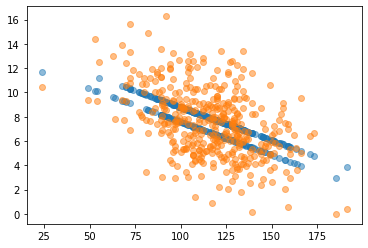

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     41.52
Date:                Sat, 16 Jan 2021   Prob (F-statistic):           2.39e-23
Time:                        10:43:27   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1863.
Df Residuals:                     396   BIC:                             1879.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0435      0.651     20.036      0.000      11.764      14.323
Price         -0.0545      0.005    -10.389      0.000      -0.065      -0.044
Urban         -0.0219      0.272     -0.081      0.936      -0.556       0.512
US             1.2006      0.259      4.635      0.000       0.691       1.710
==============================================================================
Omnibus:                        0.676   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.713   Jarque-Bera (JB):                0.758
Skew:                           0.093   Prob(JB):                        0.684
Kurtosis:                       2.897   Cond. No.                         628.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
mapping = {'Yes': 1, 'No': 0}
df = df.replace({'Urban' : mapping, 'US' : mapping})
x = df[['Price', 'Urban', 'US']].astype(float)
y = df['Sales'].astype(float)
x = sm.add_constant(x)

est = sm.OLS(y, x).fit()
yfit = est.predict(x)

fig, ax = plt.subplots() #ugly non-sense!
ax.scatter(x.iloc[:,1],yfit,alpha=0.5)
ax.scatter(x.iloc[:,1],y,alpha=0.5)
plt.show()
est.summary()

In [ ]:
'''
Question 5.2:
The price of the carseats are decreasing by $5.45 (+/- $0.50). According to the t-test, this value is significant. Since Urban and US are categorical data, we can't rely on the t-test. We would have to do a chi-square test to see how significant those values are.

Question 5.3:
Technically we can only reject our null hypothesis for the price of the carseat. If US was a quantitative value and not qualitative, we would be able to reject it too, but we would need to use a chi-square test to see if we can actually reject it.
'''

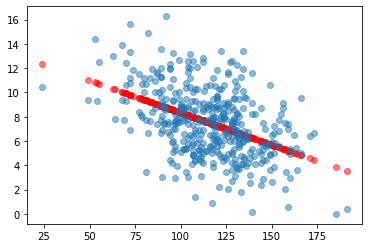

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     98.25
Date:                Sat, 16 Jan 2021   Prob (F-statistic):           7.62e-21
Time:                        11:21:38   Log-Likelihood:                -938.23
No. Observations:                 400   AIC:                             1880.
Df Residuals:                     398   BIC:                             1888.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.6419      0.633     21.558      0.000      12.398      14.886
Price         -0.0531      0.005     -9.912      0.000      -0.064      -0.043
==============================================================================
Omnibus:                        2.537   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.281   Jarque-Bera (JB):                2.611
Skew:                           0.175   Prob(JB):                        0.271
Kurtosis:                       2.816   Cond. No.                         591.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
x = df['Price'].astype(float)
y = df['Sales'].astype(float)
x = sm.add_constant(x)

model = sm.OLS(y,x).fit()

pred = model.predict(x)
fig, ax = plt.subplots()
ax.scatter(x.iloc[:,1],pred,alpha=0.5,color='r')
ax.scatter(x.iloc[:,1],y,alpha=0.5)
plt.show()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     49.07
Date:                Sat, 16 Jan 2021   Prob (F-statistic):           9.01e-20
Time:                        11:21:54   Log-Likelihood:                -938.17
No. Observations:                 400   AIC:                             1882.
Df Residuals:                     397   BIC:                             1894.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.2720      1.931      7.391      0.000      10.476      18.068
Price         -0.0646      0.034     -1.912      0.057      -0.131       0.002
Price2      5.038e-05      0.000      0.345      0.730      -0.000       0.000
==============================================================================
Omnibus:                        2.553   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.279   Jarque-Bera (JB):                2.627
Skew:                           0.176   Prob(JB):                        0.269
Kurtosis:                       2.816   Cond. No.                     2.29e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

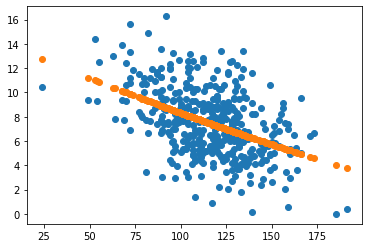

In [15]:
df['Price2'] = (df.Price ** 2).astype(float)
X = sm.add_constant(df[['Price', 'Price2']])
est = sm.OLS(y, X).fit()
yfit = est.predict(X)

plt.scatter(x.iloc[:,1], y)
plt.scatter(x['Price'],yfit)
est.summary()

In [ ]:
'''
Question 5.5:
The R-squared value is very small for both models 1 and 4. The data, however, looks the more or less the same in the graphs as all of the points are concentrated around the middle. The data is also fairly well split over and under the regression line (orange) with the outliers for both the regression line and data being close together. Based on the summary data, however, the price is significantly related to the sales in the first set of data, but not in the squared data.

Question 5.6:
Confidence interval for price: [-0.064	-0.043]
'''